In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV

from highstreets.models import train_model as tm
from highstreets.data import make_dataset as mhsd
from highstreets.visualisation import visualise as vhsd
from highstreets.features import build_features as bf

from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv())

YOY_FILE = os.environ.get("YOY_FILE")
PROFILE_FILE = os.environ.get("PROFILE_FILE")
PROJECT_ROOT = os.environ.get("PROJECT_ROOT")

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")
sns.set_context("notebook")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load mastercard spend data along with high street profiles and setup data arrays and time vectors for convenience

In [2]:
hsp = pd.read_excel(PROFILE_FILE)
hsd_yoy = pd.read_csv(YOY_FILE, parse_dates=["week_start"])

# some important dates
nb_dates = pd.to_datetime(
    [
        "2020-03-24",  # first lockdown starts
        "2020-06-15",  # shops reopen
        "2020-11-05",  # second lockdown starts
        "2020-12-02",  # back to 'tier 2' (i.e. partial reopening)
        "2021-01-05",  # third lockdown starts
        "2021-04-12",  # shops reopen
    ]
)

# average weekday and weekend expenditure (should probably relax this
# later - no need to lose information)
hsd_yoy_minimal = mhsd.avg_retail_wd_we(hsd_yoy, "yoy_")

dates_2020 = ("2020-04-15", "2020-10-31")
dates_2020_full = ("2020-01-01", "2020-12-31")
dates_2021 = ("2021-02-12", "2021-08-31")
dates_full = ("2020-01-01", "2021-12-31")

data_2020 = mhsd.extract_data_array(hsd_yoy_minimal, dates_2020, "txn_amt")
data_2021 = mhsd.extract_data_array(hsd_yoy_minimal, dates_2021, "txn_amt")
data_2020_full = mhsd.extract_data_array(hsd_yoy_minimal, dates_2020_full, "txn_amt")
data_full = mhsd.extract_data_array(hsd_yoy_minimal, dates_full, "txn_amt")

start_times = {"2020": "2020-04-01", "2021": "2021-04-12", "full": "2020-04-01"}
tvecs = {"2020": data_2020.index, "2021": data_2021.index, "full": data_full.index}
arrays = {
    "2020": np.transpose(data_2020.to_numpy()),
    "2021": np.transpose(data_2021.to_numpy()),
    "full": np.transpose(data_full.to_numpy()),
}

### Run k-means on 2020, 2021, and full data separately:

In [3]:
n_clus = 3
max_iter = 50
tol = 1e-2

# 2020 data:
kmeans20 = KMeans(
    init="random",
    n_clusters=n_clus,
    random_state=None,
    max_iter=max_iter,
    tol=tol,
    copy_x=True,
    verbose=0,
    n_init=10,
)
kmeans20.fit(np.transpose(data_2020.to_numpy()))

# 2021 data:
kmeans21 = KMeans(
    init="random",
    n_clusters=n_clus,
    random_state=None,
    max_iter=max_iter,
    tol=tol,
    copy_x=True,
    verbose=0,
    n_init=10,
)
kmeans21.fit(np.transpose(data_2021.to_numpy()))

# full data:
kmeansfull = KMeans(
    init="random",
    n_clusters=n_clus,
    random_state=None,
    max_iter=max_iter,
    tol=tol,
    copy_x=True,
    verbose=0,
    n_init=10,
)
kmeansfull.fit(np.transpose(data_full.to_numpy()))

KMeans(init='random', max_iter=50, n_clusters=3, tol=0.01)

## Regressions: trying to summarise trends across time

In [4]:
# Unpooled regression - fit slope and intercept independently for each high street
fit_lines = {}
reg_model = {}

reg_model["2020"], fit_lines["2020"] = mhsd.get_fit_lines(
    start_times["2020"], tvecs["2020"], arrays["2020"], robust=False
)
reg_model["2021"], fit_lines["2021"] = mhsd.get_fit_lines(
    start_times["2021"], tvecs["2021"], arrays["2021"], robust=False
)
reg_model["full"], fit_lines["full"] = mhsd.get_fit_lines(
    start_times["full"], tvecs["full"], arrays["full"], robust=False
)

### Plot each highstreet with lines fit to each recovery period

In [ ]:
vhsd.plot_all_profiles_full(
    {"2020": data_2020, "2021": data_2021, "full": data_full}, fit_lines
)

### Sort highstreets by their 2020 mean and 2020 fit slope and plot by group

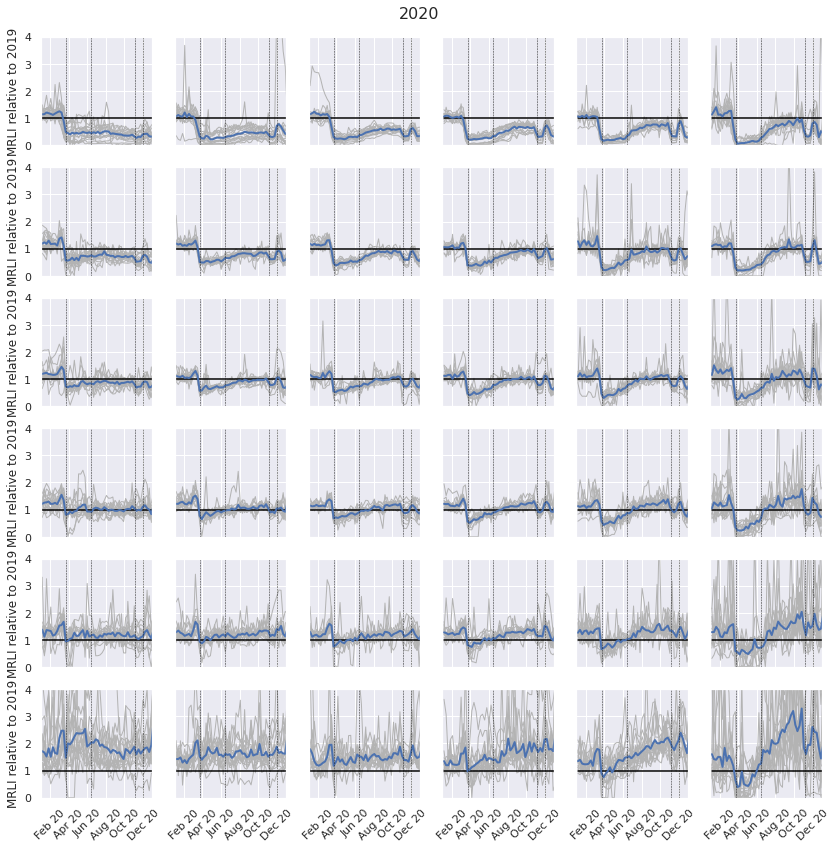

In [5]:
# columns by which we will sort the highstreets
# (for example,
# slope of the best fit line to 2020 recovery and the mean 2020)
sort_cols = (
    data_2020_full.loc[nb_dates[0] : nb_dates[3], :].mean().to_numpy(),
    reg_model["2020"].coef_,
)

plot_array = np.transpose(data_full.to_numpy())
plot_tvec = data_full.index
filename = "2020-sorted-by-mean-slope.pdf"

vhsd.plot_highstreets_grouped(
    plot_array,
    plot_tvec,
    sort_cols,
    nb_dates,
    filename,
    xlim=("2020-01-01", "2020-12-31"),
    figure_title="2020",
    n_grp=6,
)

### Sort highstreets by their 2021 mean and slope and plot in groups

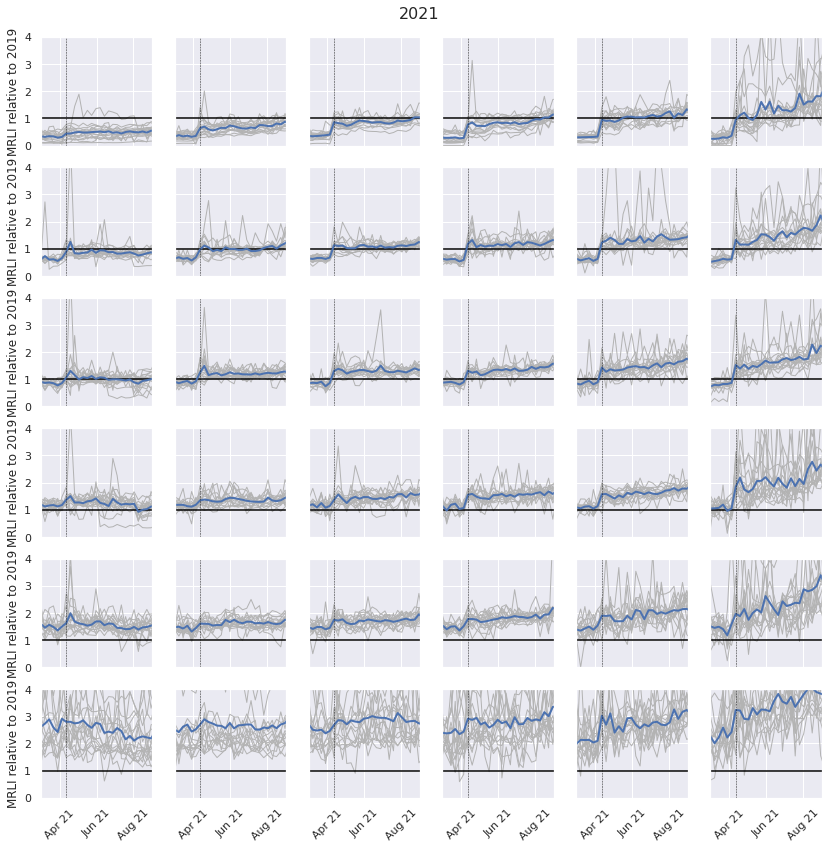

In [6]:
# columns by which we will sort the highstreets
# (for example, slope of the best fit line to 2020 recovery
# and the initial hit in 2020)
sort_cols = (
    data_2021.loc["2021-03-01" : nb_dates[-1], :].mean().to_numpy(),
    reg_model["2021"].coef_,
)

plot_array = np.transpose(data_full.to_numpy())
plot_tvec = data_full.index
filename = "2021-sorted-by-mean-slope.pdf"

vhsd.plot_highstreets_grouped(
    plot_array,
    plot_tvec,
    sort_cols,
    nb_dates,
    filename,
    xlim=("2021-03-01", "2021-09-01"),
    figure_title="2021",
    n_grp=6,
)

### Sort highstreets by their 2020 means and slopes and plot across full period sorted into groups

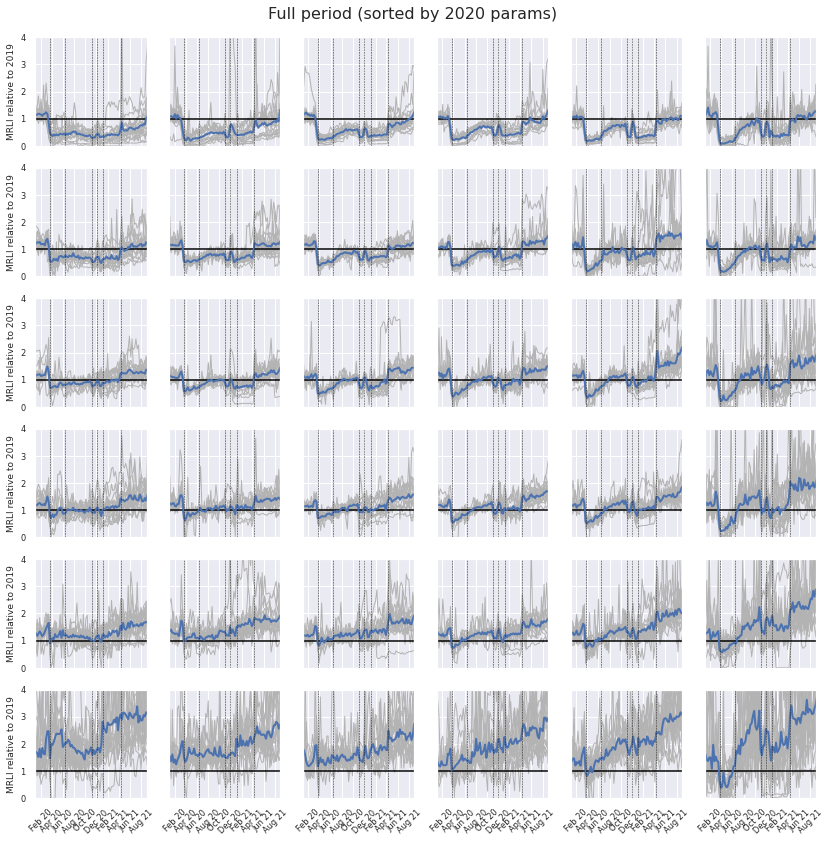

In [42]:
# columns by which we will sort the highstreets
# (for example, slope of the best fit line to 2020 recovery
# and the initial hit in 2020)
sort_cols = (
    data_2020_full.loc["2020-03-14":"2020-11-01", :].mean().to_numpy(),
    reg_model["2020"].coef_,
)

plot_array = np.transpose(data_full.to_numpy())
plot_tvec = data_full.index
filename = "full-sorted-by-2020-mean-slope.pdf"

vhsd.plot_highstreets_grouped(
    plot_array,
    plot_tvec,
    sort_cols,
    nb_dates,
    filename,
    xlim=("2020-01-01", "2021-09-01"),
    figure_title="Full period (sorted by 2020 params)",
    n_grp=6,
)

### Append 2020 & 2021 means and fit lines to High Street Profiles for further analysis

In [216]:
stats = mhsd.append_profile_features(hsp, data_full, reg_model)
stats = bf.clean_hs_profiles(stats)
stats.head()

,,mean 2020,mean 2021,slope 2020,slope 2021,percentage of commercial addresses (%),precentage of residential addresses (%),average IMD2019 score,LOAC2011_Group_Name (Rank 1),loac2011 percentage of overlap % (Rank 1),LOAC2011_Group_Name (Rank 2),...,PTAL2015 (Rank 3),ptal2015 percentage of overlap%(Rank 3),TotalPopulation,Sum_y2019_07wd,pc_chng,pct offices,pct JSA 2021,pct HW,pct work age,pct employees
highstreet_id,highstreet_name,,,,,,,,,,,,,,,,,,,,,
1,"Pimlico Road, Belgravia",0.405576,1.016912,0.005088,0.006513,12.060597,79.143992,2172.508333,City enclaves,27.362412,City central,...,3,15.317254,21448.0,7348.334699,120.850868,0.092219,0.004802,0.446848,0.697454,1.547930
2,"Queensway, Westbourne Grove, Bayswater",0.353955,0.754382,0.002212,0.003251,10.004793,79.678888,1786.083333,Educational advantage,40.146481,City central,...,5,11.397149,21947.0,7354.840627,132.928899,0.049245,0.004329,0.472684,0.736365,0.452226
4,"Mitcham Road, Croydon.",1.342439,3.070515,-0.001391,0.006037,6.657224,82.530689,3608.950000,Struggling suburbs,45.035519,Public sector & service employees,...,4,7.954378,3355.0,1141.060698,116.588912,0.003777,0.005365,1.307899,0.636364,0.812221
5,"Bridge Road, Chessington.",0.874485,1.420162,0.003298,0.000814,8.472856,86.174531,1153.216667,Not quite Home Counties,48.940653,Suburban localities,...,1a,6.393813,9318.0,2159.100879,124.552195,0.034754,0.006010,0.308972,0.627281,0.300494
6,"Brighton Road, Purley Oaks.",0.859606,1.238338,0.004919,0.001277,7.789256,84.111570,1590.750000,Struggling suburbs,27.539548,Affluent suburbs,...,3,26.868873,11260.0,2693.808580,121.422534,0.012397,0.003197,0.326110,0.647957,0.270870


### Fit some simple regressions

In [218]:
data = pd.get_dummies(stats)

target_variables = [
    "mean 2020",
    "mean 2021",
    "slope 2020",
    "slope 2021",
]

target_col = "slope 2020"
y = data[target_col]
X = data.drop(columns=target_col)

scaler = StandardScaler()
scaler.fit(X)
X_sc = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.2)

In [192]:
base_model = LinearRegression()

alphas = [0.0001, 0.2, 0.6, 1, 4, 8, 80, 800]
ridge = RidgeCV(alphas)

results_linear = tm.run_experiment(base_model, X_train, X_test, y_train, y_test)
results_ridge = tm.run_experiment(ridge, X_train, X_test, y_train, y_test)

In [193]:
y_pred_ridge = results_ridge["model"].predict(X_test)
y_pred = results_linear["model"].predict(X_test)

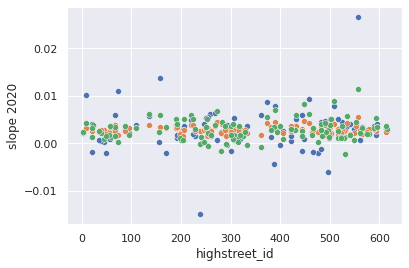

In [206]:
sns.scatterplot(x=y_test.index.droplevel(1), y=y_test)
sns.scatterplot(x=y_test.index.droplevel(1), y=y_pred_ridge)
sns.scatterplot(x=y_test.index.droplevel(1), y=y_pred)
plt.savefig(PROJECT_ROOT + "/reports/figures/predicted_vs_actual_slopes.pdf")

In [97]:
cat_vars = [
    "LOAC2011_Group_Name (Rank 1)",
    "LOAC2011_Group_Name (Rank 2)",
    "LOAC2011_Group_Name (Rank 3)",
    "PTAL2015 (Rank 1)",
    "PTAL2015 (Rank 2)",
    "PTAL2015 (Rank 3)",
]

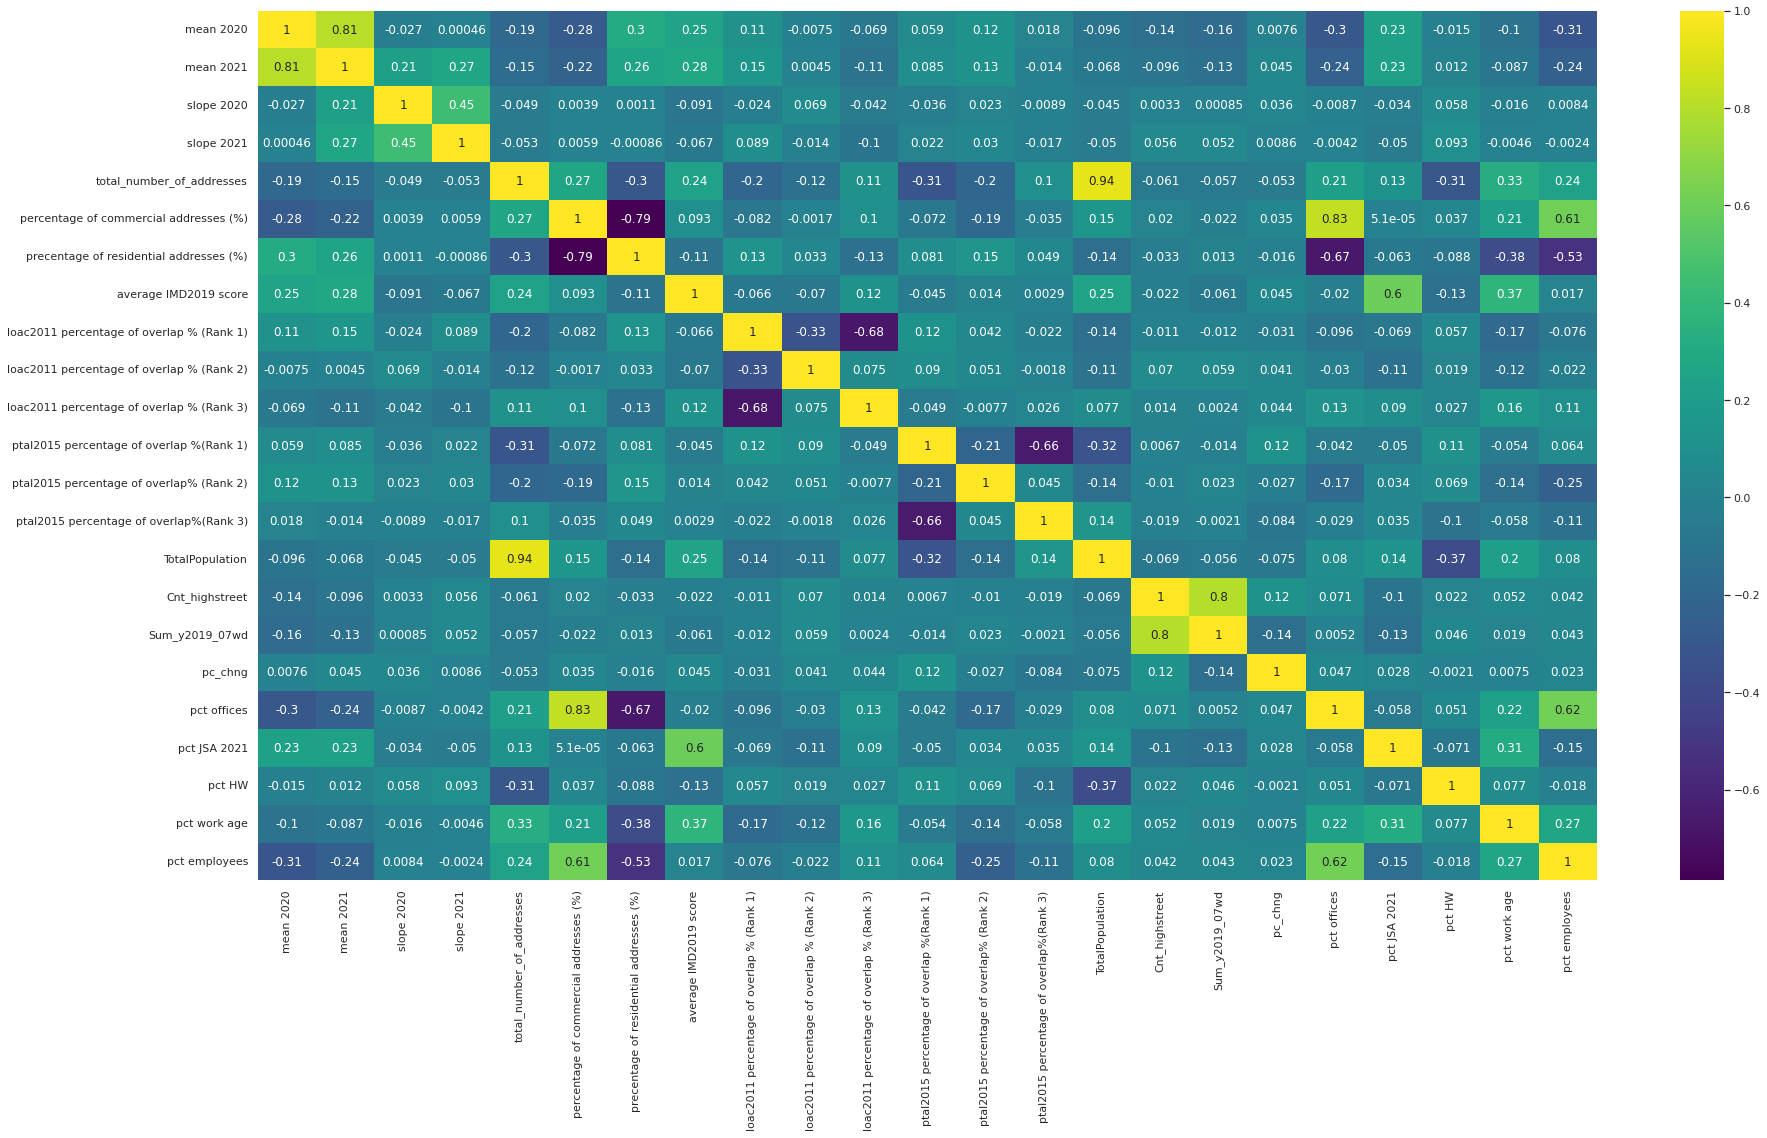

In [209]:
plt.figure(figsize=(30, 16))
sns.heatmap(stats.drop(columns=cat_vars).corr(), annot=True, cmap="viridis")
plt.savefig(PROJECT_ROOT + "/reports/figures/feature-correlations.pdf")